In [ ]:
!pip install transformers
!pip install pytorch_lightning
!pip install wandb

     |████████████████████████████████| 4.0 MB 12.0 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.5 MB 43.2 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 582 kB 12.2 MB/s 
     |████████████████████████████████| 398 kB 44.6 MB/s 
     |████████████████████████████████| 136 kB 45.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.0 MB/s 
     |████████████████████████████████| 144 kB 51.1 MB/s 
     |████████████████████████████████| 271 kB 51.6 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Succes

Clean & Wrangle the Data

In [ ]:
!mkdir datasets

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('datasets/train.csv')
cpc_scheme_data = pd.read_csv('datasets/cpc_scheme_data.csv')

In [ ]:
unique_score_values = sorted(list(set(data['score'].values)))
mapper = {str(value): count for count, value in enumerate(unique_score_values)}
mapper

{'0.0': 0, '0.25': 1, '0.5': 2, '0.75': 3, '1.0': 4}

In [ ]:
def label2str(label):
  mapper_reverse = {str(v): k for k, v in mapper.items()}
  mapper_str = {
      '0.0': 'Not Related',
      '0.25': 'Maybe Not Related',
      '0.5': 'Weakly Related',
      '0.75': 'Related', 
      '1.0': 'Strongly Related',
  }
  return mapper_str[mapper_reverse[str(label)]]

label2str(2)

'Weakly Related'

In [ ]:
def score2index(score):
  return mapper[str(score)]

data['label'] = data['score'].apply(score2index)

In [ ]:
data.head()

,id,anchor,target,context,score,label
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,3
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,1
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0


In [ ]:
cpc_scheme_data = cpc_scheme_data.rename({'classification': 'context', 'description': 'description'}, axis=1)
cpc_scheme_data.head()

,context,description
0,A,HUMAN NECESSITIES
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...
2,A21,BAKING; EDIBLE DOUGHS
3,A22,BUTCHERING; MEAT TREATMENT; PROCESSING POULTRY...
4,A23,"FOODS OR FOODSTUFFS; TREATMENT THEREOF, NOT CO..."


In [ ]:
def merge(df1, df2):
  df1 = df1.merge(df2, how='left', on=['context'])

  return df1

data = merge(data, cpc_scheme_data)

In [ ]:
data.head()

,id,anchor,target,context,score,label,description
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,2,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,3,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,1,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,2,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [ ]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [ ]:
train_data, rem_data = train_test_split(data, train_size=0.8)
val_data, test_data = train_test_split(rem_data, test_size=0.5)
train_data.shape, val_data.shape, test_data.shape

((29178, 7), (3647, 7), (3648, 7))

Define the Dataset Class

In [ ]:
class P2PForSequenceClassification(Dataset):
  def __init__(self, tokenizer, data):
    self.tokenizer = tokenizer
    self.data = data

    self.inputs = []
    self.labels = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def _build_context(self, p1, p2, context):
    prompt = f'context: {context}. Are {p1}: {p2} related?'
    return prompt

  def _build(self):
    for phrase_1, phrase_2, context, label in zip(
        self.data['anchor'], self.data['target'], self.data['description'], self.data['label']):
      context = self._build_context(phrase_1, phrase_2, context)
      input_token_ids = self.tokenizer.encode_plus(
          context, padding='max_length', max_length=512, return_tensors='pt')
      self.inputs.append(input_token_ids)
      self.labels.append(label)

  # def __getitem__(self, index):
  #   input_ids = self.inputs[index]['input_ids'].squeeze()
  #   attention_mask = self.inputs[index]['attention_mask'].squeeze()
  #   labels = torch.tensor(self.labels[index], dtype=torch.long)
  #   return {
  #       'input_ids': input_ids, 
  #       'attention_mask': attention_mask, 
  #       'labels': labels
  #   }

  def __getitem__(self, index):
    input_ids = self.inputs[index]['input_ids'].squeeze()
    attention_mask = self.inputs[index]['attention_mask'].squeeze()
    token_type_ids = self.inputs[index]['token_type_ids'].squeeze()
    labels = torch.tensor(self.labels[index], dtype=torch.long)
    return {
        'input_ids': input_ids, 
        'attention_mask': attention_mask, 
        'token_type_ids': token_type_ids, 
        'labels': labels
    }

  

Training

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, AdamW

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# model_ckpt = 'distilbert-base-uncased'
# model_ckpt = 'bert-base-uncased'
model_ckpt = 'anferico/bert-for-patents'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, padding=True)
tokenizer.model_max_length

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

1000000000000000019884624838656

In [ ]:
tokenizer.vocab_size

39859

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
test_dataset = P2PForSequenceClassification(tokenizer, test_data)

In [ ]:
len(test_dataset)

3648

In [ ]:
test_dataset[2]['token_type_ids']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(tokenizer.decode(test_dataset[5]['input_ids'], skip_special_tokens=True))

context : optics. are form as body : form filling related?


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=5).to(device)

Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

In [ ]:
class BertP2pFineTuner(pl.LightningModule):
  def __init__(self):
    super().__init__()

  def load_model(self, tokenizer, model, hyperparameters):
    self.tokenizer = tokenizer
    self.model = model
    self.hyperparameters = hyperparameters

  def _get_predictions(self, logits):
    predictions_list = []
    for pred in logits:
      log_probs = F.softmax(pred, dim=0)
      token_id = torch.argmax(log_probs).item()
      classification = label2str(token_id)
      predictions_list.append(classification)
    return predictions_list

  def training_step(self, batch, batch_idx):
    outputs = self.model(input_ids=batch['input_ids'],
                         attention_mask=batch['attention_mask'],
                         token_type_ids=batch['token_type_ids'],
                         labels=batch['labels'])
    
    loss = outputs.loss
    logits = outputs.logits

    preds = self._get_predictions(logits)
    # print(preds)

    return{
        'loss': loss
    }

  def training_step_end(self, outputs):
    self.log('train_loss', outputs['loss'])

  def training_epoch_end(self, outputs):
    avg_training_loss = torch.stack([x['loss'] for x in outputs]).mean()
    self.log('average_training_loss', avg_training_loss)

  def validation_step(self, batch, batch_idx):
    outputs = self.model(input_ids=batch['input_ids'],
                         attention_mask=batch['attention_mask'],
                         labels=batch['labels'])
    
    loss = outputs.loss

    return {
        'loss': loss
    }

  def validation_step_end(self, outputs):
    self.log('validation loss', outputs['loss'])

  def configure_optimizers(self):
    model = self.model
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_params = [
                            {
                                'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                                'weight_decay': self.hyperparameters['weight_decay']
                            },
                            {
                                'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                                'weight_decay': 0.0
                            }
    ]
    optimizer = AdamW(optimizer_grouped_params, lr=self.hyperparameters['learning_rate'], eps=self.hyperparameters['adam_epsilon'])
    self.opt = optimizer
    return [optimizer]

  def train_dataloader(self):
    train_dataset = P2PForSequenceClassification(self.tokenizer, self.hyperparameters['train_data'])
    dataloader = DataLoader(
        train_dataset, batch_size=self.hyperparameters['train_batch_size'], drop_last=True, shuffle=True, num_workers=2)
    t_total = (
        (len(dataloader.dataset) // (self.hyperparameters['train_batch_size'] * max(1, self.hyperparameters['n_gpu'])))
        // self.hyperparameters['gradient_accumulation_steps']
        * float(self.hyperparameters['num_train_epochs'])
    )

    scheduler = get_linear_schedule_with_warmup(self.opt, 
                                                num_warmup_steps=self.hyperparameters['warmup_steps'], 
                                                num_training_steps=t_total)
    self.lr_scheduler = scheduler
    
    return dataloader
    
  def val_dataloader(self):
    val_dataset = P2PForSequenceClassification(self.tokenizer, self.hyperparameters['val_data'])
    return DataLoader(
        val_dataset, batch_size=self.hyperparameters['eval_batch_size'], drop_last=True, shuffle=True, num_workers=2)
    

In [ ]:
hyperparameters = {
    'data_dir': 'final',
    'output_dir': 'bert-finetuned-p2p',
    'train_data': train_data, 
    'val_data': val_data, 
    'train_batch_size': 4,
    'eval_batch_size': 8, 
    'num_train_epochs': 2,
    'learning_rate': 2e-5, 
    'weight_decay': 0.0, 
    'adam_epsilon': 1e-08, 
    'warmup_steps': 0, 
    'max_seq_length': 512, 
    'gradient_accumulation_steps': 16, 
    'n_gpu': 1,
    'fp_16': False,
    'seed': 43
}

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='bert-p2p', log_model='all')

In [ ]:
import argparse

args_dict = hyperparameters
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, monitor="val_loss", mode="min", save_top_k=5
)

training_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    checkpoint_callback=checkpoint_callback,
    logger=wandb_logger,
    weights_summary='full'
)

In [ ]:
model_ft = BertP2pFineTuner()
model_ft.load_model(tokenizer, model, hyperparameters)

In [ ]:
trainer = pl.Trainer(**training_params)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f618d167110>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f618d167110>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:192: LightningDeprecationWarning: Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.
  f"Setting `Trainer(weights_summary={weights_summary})` is deprecated in v1.5 and w

In [ ]:
wandb_logger.watch(model_ft, log='all')

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
trainer.fit(model_ft)

Save the Model

In [ ]:
!mkdir fined_tuned_model_phrase2phrase_bertbase

In [ ]:
model_ft.model.save_pretrained('fined_tuned_model_phrase2phrase_bertbase')

In [ ]:
!tar -czvf model.tar.gz fined_tuned_model_phrase2phrase_bertbase/

fined_tuned_model_phrase2phrase_bertbase/
fined_tuned_model_phrase2phrase_bertbase/config.json
fined_tuned_model_phrase2phrase_bertbase/pytorch_model.bin


In [ ]:
from google.colab import files
files.download('model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test the Model

In [ ]:
model_ft.model.to(device)

In [ ]:
loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
it = iter(loader)
batch = next(it)
batch['input_ids'].shape

torch.Size([8, 512])

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  
  with torch.no_grad():
    outs = model.forward(input_ids=batch['input_ids'].to(device), 
                       attention_mask=batch['attention_mask'].to(device),
                       token_type_ids=batch['token_type_ids'].to(device))
    logits = outs.logits

  # print(logits)

  prediction_class_ids = [logit.argmax().item() for logit in logits]
  print(prediction_class_ids)

  target = np.array(batch['labels']).tolist()
  # print(target)
  
  outputs.extend(prediction_class_ids)
  targets.extend(target)

  0%|          | 0/456 [00:00<?, ?it/s]

[1, 1, 2, 0, 2, 2, 1, 2]
[0, 1, 0, 1, 2, 3, 2, 2]
[2, 2, 0, 0, 1, 2, 1, 1]
[2, 1, 2, 4, 2, 1, 2, 2]
[2, 1, 1, 0, 1, 1, 2, 2]
[0, 0, 2, 2, 1, 2, 1, 1]
[3, 2, 1, 0, 0, 2, 2, 0]
[4, 2, 2, 1, 1, 0, 2, 4]
[0, 2, 1, 1, 0, 0, 2, 2]
[4, 1, 0, 1, 0, 4, 2, 1]
[0, 0, 0, 2, 1, 1, 0, 3]
[1, 1, 4, 2, 1, 1, 3, 1]
[0, 2, 2, 1, 3, 2, 0, 2]
[2, 2, 1, 1, 1, 0, 1, 1]
[0, 1, 2, 1, 4, 2, 2, 0]
[1, 1, 0, 0, 2, 2, 1, 1]
[1, 0, 1, 2, 1, 1, 1, 2]
[2, 2, 0, 2, 1, 2, 3, 0]
[0, 1, 4, 2, 3, 2, 0, 1]
[2, 1, 1, 3, 1, 2, 2, 1]
[2, 1, 2, 1, 0, 2, 2, 1]
[0, 1, 2, 2, 1, 4, 1, 0]
[0, 1, 2, 1, 2, 1, 4, 0]
[2, 1, 2, 1, 2, 2, 2, 3]
[2, 2, 1, 1, 4, 2, 1, 2]
[0, 2, 1, 1, 1, 1, 1, 1]
[1, 0, 2, 2, 3, 1, 4, 2]
[1, 1, 2, 0, 1, 1, 4, 2]
[4, 2, 2, 3, 1, 1, 2, 2]
[0, 2, 2, 2, 2, 3, 2, 2]
[4, 1, 1, 1, 1, 1, 2, 2]
[2, 2, 0, 2, 2, 0, 0, 2]
[2, 0, 0, 2, 2, 0, 0, 2]
[3, 1, 2, 4, 1, 2, 0, 2]
[2, 1, 2, 1, 2, 2, 1, 0]
[1, 1, 1, 1, 4, 1, 1, 2]
[2, 0, 2, 1, 2, 0, 2, 1]
[0, 1, 3, 3, 1, 2, 0, 3]
[1, 0, 2, 3, 1, 1, 2, 1]
[4, 1, 1, 3, 1, 2, 0, 2]


In [ ]:
set(outputs)

{0, 1, 2, 3, 4}

In [ ]:
acc = accuracy_score(targets, outputs)
acc

0.6746162280701754

In [ ]:
f1 = f1_score(targets, outputs, average='weighted')
f1

0.6687996467674777

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(5, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized Confusion Matrix')
  plt.show()

In [ ]:
mapper_str = {
      '0.0': 'Not Related',
      '0.25': 'Maybe Not Related',
      '0.5': 'Weakly Related',
      '0.75': 'Related', 
      '1.0': 'Strongly Related',
  }
labels_list = list(mapper_str.values())
labels_list

['Not Related',
 'Maybe Not Related',
 'Weakly Related',
 'Related',
 'Strongly Related']

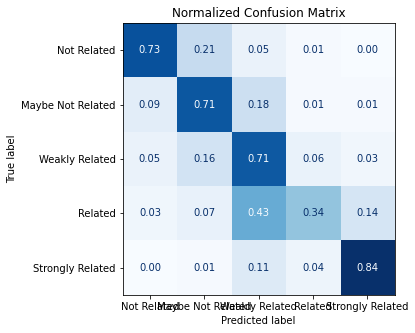

In [ ]:
plot_confusion_matrix(outputs, targets, labels_list)